1. Import libraries and dependencies

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Importar tus módulos locales
import utils
import analysis_helpers

# Configuración de semillas para reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


2. Load and preprocess data

In [ ]:
# Cargar el dataset usando kagglehub
file_path = "sp500_data.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "shannanl/sp500-dataset",
    file_path,
)
df.rename(columns={df.columns[0]: "day"}, inplace=True)

# Seleccionar un ticker de ejemplo (High Vol / High Liquidity según tu análisis previo)
ticker = "AAPL"
print(f"Loading data for: {ticker}")

# Usar la función de utils para cargar y limpiar datos específicos
df_stock = utils.load_comp_data(df, ticker)

# Calcular características técnicas (RSI, Bollinger, Volatility, etc.)
# Esto también normaliza las features (z-score) y crea el target 'log_next_day_max_return'
WINDOW_SIZE = 20
df_fe = utils.compute_features(df_stock, w=WINDOW_SIZE, cut=True)

# Eliminar filas con NaN que puedan haber quedado (por shifts del target)
df_fe.dropna(inplace=True)

print("Features calculated. Shape:", df_fe.shape)
df_fe.tail()

/tmp/ipython-input-3148078881.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'sp500-dataset' dataset.
Loading data for: AAPL


/content/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)


Features calculated. Shape: (5461, 31)


,timestep,AAPL_high,AAPL_low,AAPL_open,AAPL_close,AAPL_volume,log_return,true_range,rsd_20,ntv_20,...,bollinger_mid,bollinger_upper,bollinger_lower,bollinger_width,bollinger_percent_b,rsi_w,obv,volume_z,candle_body,candle_range_ratio
5456,5477,-0.593097,-0.194214,-0.233947,-0.538862,-1.263644,-0.580691,-1.391396,-2.480652,-1.217181,...,-1.966097,-2.571103,-0.996733,-0.998399,1.110811,-0.096655,0.565762,-1.426418,-0.574347,-1.274717
5457,5478,-0.289042,-0.358134,-0.702262,-0.493662,-0.899623,0.501146,0.031912,-2.115457,-0.829901,...,-1.827024,-2.323619,-0.865878,-1.331640,1.219799,-0.192416,-0.031948,-0.937242,0.501806,0.468281
5458,5479,-0.848506,-0.558214,-0.297249,-0.877397,-0.427938,-1.076568,-0.714177,-1.948051,-0.316907,...,-1.714997,-2.084672,-0.827456,-1.433247,0.445438,-0.128857,-0.804448,-0.348460,-1.070846,-1.438728
5459,5480,-1.553588,-1.145604,-0.967597,-1.037309,-0.138639,-0.084412,-0.561067,-1.751735,-0.017193,...,-1.649681,-1.981309,-0.733286,-1.647289,0.180068,-0.420508,-1.585818,0.011755,-0.080138,-0.152514
5460,5481,-0.323117,-0.158679,-0.546650,0.274642,-0.575012,1.205837,0.086429,-1.299038,-0.429253,...,-1.551939,-1.909303,-0.476234,-1.943495,2.413005,0.550171,-0.670896,-0.483383,1.207771,1.422966


3. Data Preparation for Deep Learning


In [ ]:
# 1. Separar Features (X) y Target (y)
# 'utils.compute_features' ya normalizó las columnas de features, pero debemos quitar las no numéricas/targets
drop_cols = ["timestep", "log_next_day_max_return"]
feature_cols = [c for c in df_fe.columns if c not in drop_cols]

X = df_fe[drop_cols + feature_cols].drop(columns=drop_cols).values
y = df_fe["log_next_day_max_return"].values.reshape(-1, 1)

# 2. División Temporal (Train/Test) - Respetando el orden cronológico
TRAIN_SPLIT = 0.8
split_idx = int(len(X) * TRAIN_SPLIT)

X_train_raw, X_test_raw = X[:split_idx], X[split_idx:]
y_train_raw, y_test_raw = y[:split_idx], y[split_idx:]

# 3. Escalar el Target (y)
# Es buena práctica escalar la salida en regresión con redes neuronales
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_test_scaled = scaler_y.transform(y_test_raw)

print(f"Train samples: {len(X_train_raw)}, Test samples: {len(X_test_raw)}")

Train samples: 4368, Test samples: 1093


4. Sequence Generation

In [ ]:
def create_sequences(X, y, time_steps=30):
    """
    Convierte arrays 2D en secuencias 3D para modelos temporales (RNN/Transformer).
    Input X: (N_samples, N_features)
    Input y: (N_samples, 1)
    Output Xs: (N_samples - time_steps, time_steps, N_features)
    Output ys: (N_samples - time_steps, 1)
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30 # Mirar 30 días hacia atrás

X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_scaled, TIME_STEPS)

print(f"Training shape: X={X_train_seq.shape}, y={y_train_seq.shape}")
print(f"Testing shape:  X={X_test_seq.shape}, y={y_test_seq.shape}")

Training shape: X=(4338, 30, 29), y=(4338, 1)
Testing shape:  X=(1063, 30, 29), y=(1063, 1)


5. Transformer Model Architecture

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(
    input_shape,
    head_size=32,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[128],
    dropout=0.4, # Slightly lower dropout usually works better for finance than NLP
    mlp_dropout=0.4,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # --- Transformer Blocks ---
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # --- Global Pooling ---
    # Promediamos la salida de todos los pasos temporales
    x = layers.Flatten()(x)

    # --- MLP Head (Regresión) ---
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1)(x) # Salida lineal para regresión

    return keras.Model(inputs, outputs)

# Construir el modelo
input_shape = X_train_seq.shape[1:] # (TimeSteps, Features)

model_transformer = build_transformer_model(
    input_shape,
    head_size=64,            # Tamaño del vector de embedding por cabeza
    num_heads=4,             # Número de cabezas de atención
    ff_dim=128,              # Dimensión interna de la capa FeedForward
    num_transformer_blocks=2,# Cantidad de bloques encoder apilados
    mlp_units=[64],          # Capas densas finales
    dropout=0.1,
    mlp_dropout=0.1
)

model_transformer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.Huber(),
    metrics=["mae"]
)

model_transformer.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 30, 29)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 29)    │         58 │ input_layer_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 29)    │     30,493 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 30, 29)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 30, 29)    │          0 │ dropout_15[0][0], │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 29)    │         58 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 30, 128)   │      3,840 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 30, 128)   │          0 │ conv1d_8[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 30, 29)    │      3,741 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 30, 29)    │          0 │ conv1d_9[0][0],   │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 29)    │         58 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 29)    │     30,493 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 30, 29)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 30, 29)    │          0 │ dropout_18[0][0], │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 29)    │         58 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 30, 128)   │      3,840 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 30, 128)   │          0 │ conv1d_10[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 30, 29)    │      3,741 │ dropout_19[0][0]

 Total params: 132,189 (516.36 KB)

 Trainable params: 132,189 (516.36 KB)

 Non-trainable params: 0 (0.00 B)

6. Training

Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - loss: 0.9763 - mae: 1.4010 - val_loss: 0.4220 - val_mae: 0.7980 - learning_rate: 1.0000e-04
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.5993 - mae: 0.9854 - val_loss: 0.3256 - val_mae: 0.6752 - learning_rate: 1.0000e-04
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.4664 - mae: 0.8288 - val_loss: 0.2786 - val_mae: 0.6163 - learning_rate: 1.0000e-04
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 0.3917 - mae: 0.7380 - val_loss: 0.2269 - val_mae: 0.5454 - learning_rate: 1.0000e-04
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.3536 - mae: 0.6935 - val_loss: 0.2119 - val_mae: 0.5341 - learning_rate: 1.0000e-04
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.3342 - mae: 0.6668 - val_loss: 0.1869 - val_mae: 0.4981 - learning_rate: 1.0000e-04
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.3190 - mae: 0.6414 - val_loss: 0.1824 - val_m

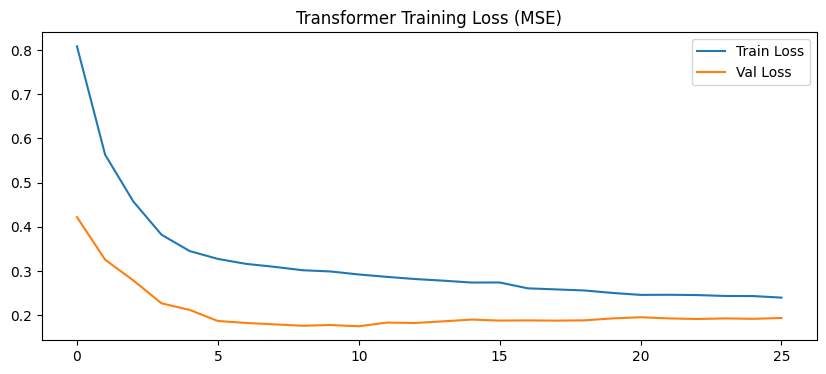

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
]

history = model_transformer.fit(
    X_train_seq,
    y_train_seq,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Graficar pérdida
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Transformer Training Loss (MSE)')
plt.legend()
plt.show()

7. Evaluation and Visualization

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

=== Transformer Performance on AAPL ===
MSE: 0.000268
MAE: 0.011739
R2:  -0.118705


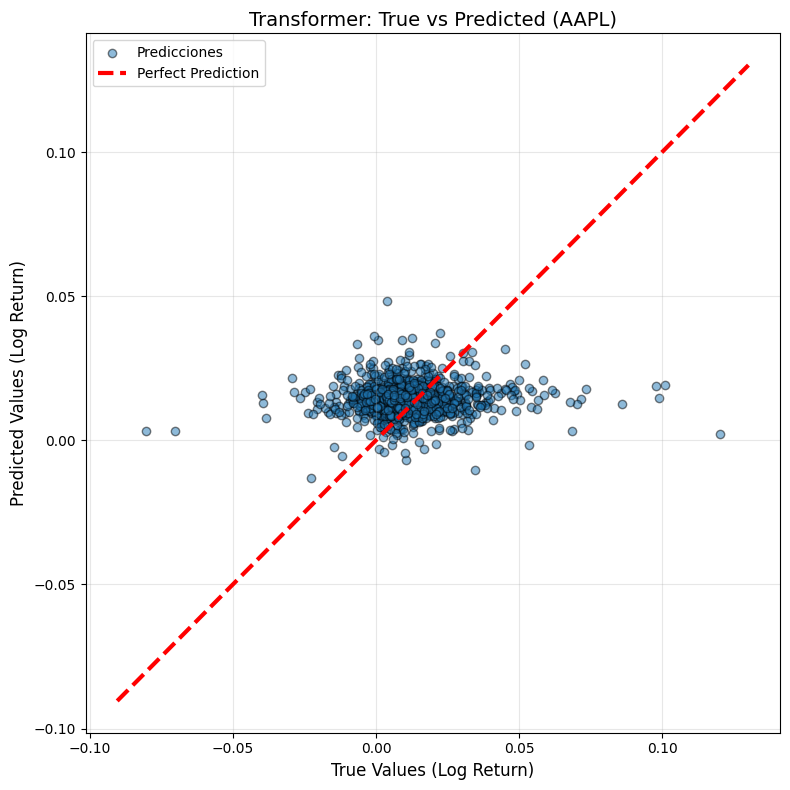

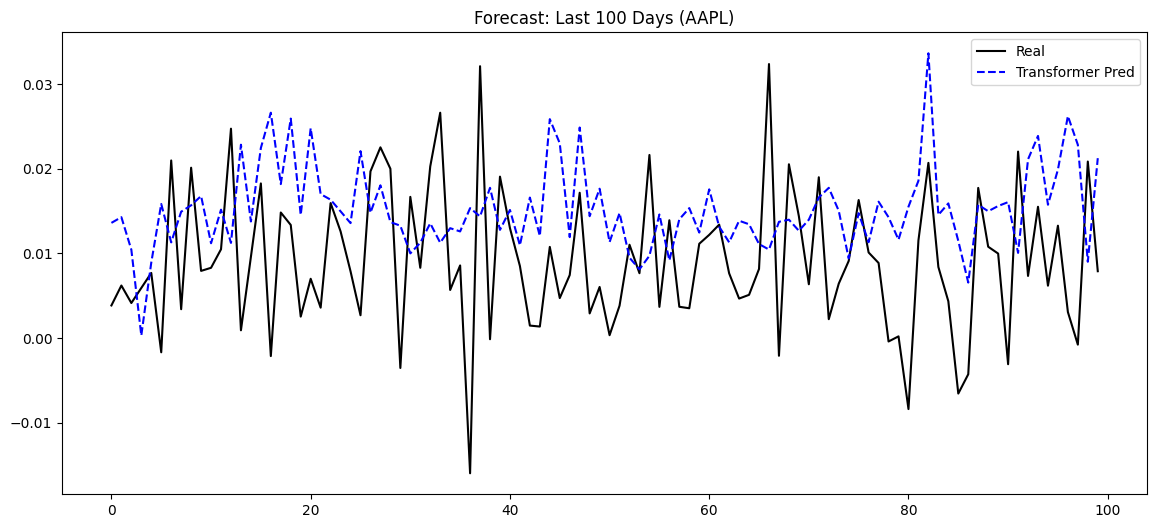

In [ ]:
# 1. Predecir
y_pred_scaled = model_transformer.predict(X_test_seq)

# 2. Invertir escalado (Volver a la magnitud original de log return)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)

# 3. Métricas
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\n=== Transformer Performance on {ticker} ===")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R2:  {r2:.6f}")

# 4. Visualización (Scatter Plot Pred vs Real)
def plot_prediction_vs_actual(y_true, y_pred, title=''):
    fig, ax = plt.subplots(figsize=[8, 8])
    ax.scatter(y_true, y_pred, alpha=0.5, edgecolors='k', label='Predicciones')

    # Línea perfecta
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'r--', lw=3, label='Perfect Prediction')

    ax.set_xlabel('True Values (Log Return)', fontsize=12)
    ax.set_ylabel('Predicted Values (Log Return)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_prediction_vs_actual(y_true, y_pred, title=f'Transformer: True vs Predicted ({ticker})')

# 5. Visualización Serie Temporal (Zoom en los últimos 100 días)
plt.figure(figsize=(14, 6))
plt.plot(y_true[-100:], label='Real', color='black')
plt.plot(y_pred[-100:], label='Transformer Pred', color='blue', linestyle='--')
plt.title(f"Forecast: Last 100 Days ({ticker})")
plt.legend()
plt.show()